In [1]:
#Topic Modelling for a corpus of PubMed Abstracts
#15068 abstracts converted into a .csv corpus
#Preprocessing the text
#Coherence Score Calculated
#Topic-Document matrix output

In [2]:
import functions

In [3]:
functions.outputs.make_csv("/Users/manojarachige/Documents/Coding/BMedScDOC1/Assets/Abstracts", "txt")

In [4]:
#csv called corpus.csv saved to current working directory

In [5]:
import pandas as pd
import csv

df=pd.read_csv('corpus.csv', encoding = 'unicode_escape', encoding_errors = 'ignore', engine ='c')
print("There are a total of {} Abstracts".format(len(df)))
df.head()

There are a total of 15068 Abstracts


,name,text
0,10024918.txt,\n1. QJM. 1998 Sep;91(9):635-40.\n\nDelay in p...
1,10025429.txt,\n1. Arch Neurol. 1999 Feb;56(2):229-34.\n\nMo...
2,10025786.txt,\n1. Neurology. 1999 Feb;52(3):551-6.\n\nA cro...
3,10026657.txt,\n1. J Gerontol A Biol Sci Med Sci. 1999 Jan;5...
4,10027037.txt,\n1. Acta Anaesthesiol Scand. 1999 Feb;43(2):2...


In [6]:
df['processed_text'] = df['text'].apply(functions.processing.preprocess)
df.head()

,name,text,processed_text
0,10024918.txt,\n1. QJM. 1998 Sep;91(9):635-40.\n\nDelay in p...,"[qjm, sepdelay, presentation, patient, acute, ..."
1,10025429.txt,\n1. Arch Neurol. 1999 Feb;56(2):229-34.\n\nMo...,"[arch, neurol, febmonitore, venous, hemodynami..."
2,10025786.txt,\n1. Neurology. 1999 Feb;52(3):551-6.\n\nA cro...,"[neurology, feba, crossethnic, analysis, risk,..."
3,10026657.txt,\n1. J Gerontol A Biol Sci Med Sci. 1999 Jan;5...,"[gerontol, biol, sci, med, sci, janmserum, ant..."
4,10027037.txt,\n1. Acta Anaesthesiol Scand. 1999 Feb;43(2):2...,"[acta, anaesthesiol, scand, febpituitary, apop..."


In [7]:
df["word_count"] = df["processed_text"].apply(lambda x: len(x))
#add in a line to remove 0 wc texts
df = df[~(df.word_count == 0)]

df.head()

,name,text,processed_text,word_count
0,10024918.txt,\n1. QJM. 1998 Sep;91(9):635-40.\n\nDelay in p...,"[qjm, sepdelay, presentation, patient, acute, ...",110
1,10025429.txt,\n1. Arch Neurol. 1999 Feb;56(2):229-34.\n\nMo...,"[arch, neurol, febmonitore, venous, hemodynami...",187
2,10025786.txt,\n1. Neurology. 1999 Feb;52(3):551-6.\n\nA cro...,"[neurology, feba, crossethnic, analysis, risk,...",176
3,10026657.txt,\n1. J Gerontol A Biol Sci Med Sci. 1999 Jan;5...,"[gerontol, biol, sci, med, sci, janmserum, ant...",145
4,10027037.txt,\n1. Acta Anaesthesiol Scand. 1999 Feb;43(2):2...,"[acta, anaesthesiol, scand, febpituitary, apop...",121


In [8]:
# Descriptive statistics for word count
df['word_count'].describe()
#95%CI Calculated: 

count    14959.000000
mean       137.746373
std         78.178117
min          6.000000
25%         92.000000
50%        134.000000
75%        177.000000
max       2506.000000
Name: word_count, dtype: float64

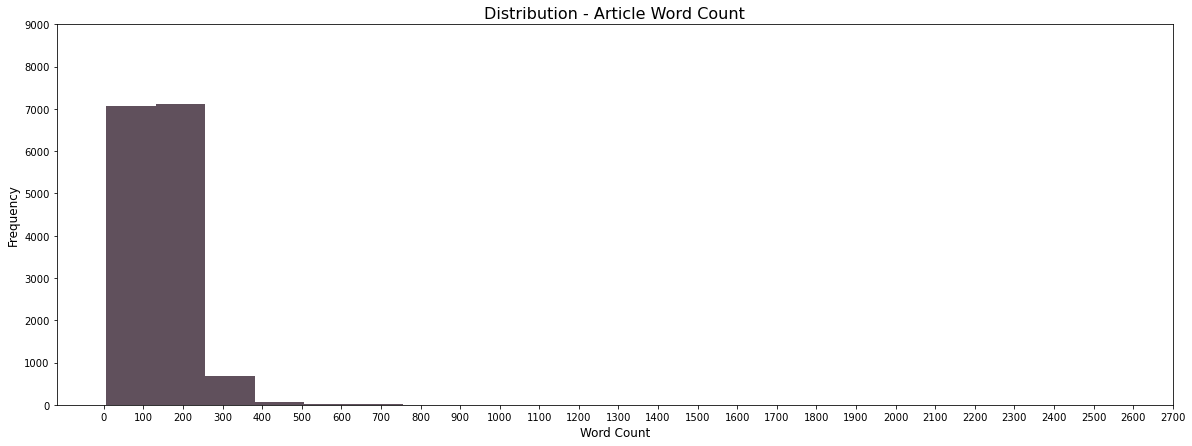

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Plot a hist of the word counts
fig = plt.figure(figsize=(20,7))

plt.hist(
    df['word_count'],
    bins=20,
    color='#60505C'
)

plt.title('Distribution - Article Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(np.arange(0, 10000, 1000))
plt.xticks(np.arange(0, 2800, 100))

file_name = 'hist'

plt.show()

In [10]:
from collections import Counter

# Get the top 20 most common words among all the articles
p_text = df['processed_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

,word,frequency
0,patient,31744
1,university,14010
2,index,13986
3,consciousness,13904
4,information,13342
5,medline,13331
6,department,10287
7,case,9915
8,hospital,9778
9,study,9584


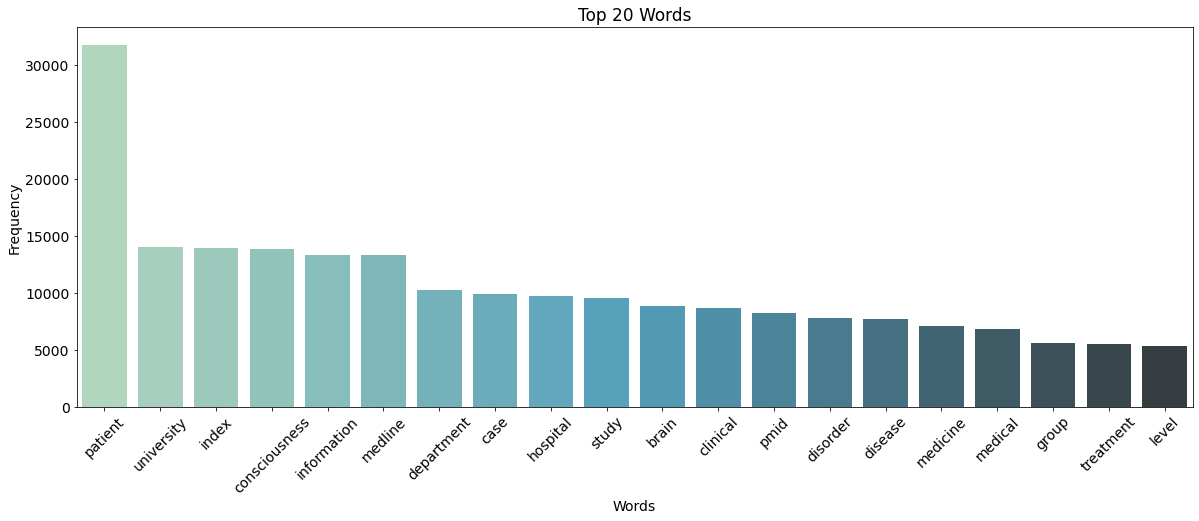

In [11]:
import seaborn as sns

# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)

plt.show()

In [12]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

261926

In [13]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter

In [14]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below = 3,
    no_above=0.85,
    #keep_n=5000, removed so that we're not setting a limit for number of words
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

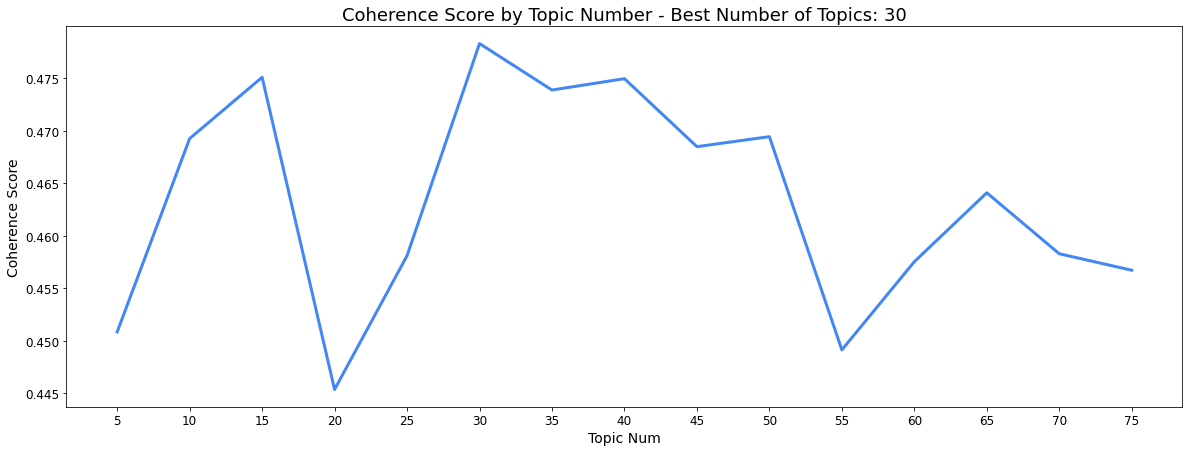

In [15]:
# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(20, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [16]:
# Now use the number of topics with the 
# highest coherence score to run the 
# sklearn nmf model

texts = df['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    #max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

In [17]:
#functions for creating topic display table 

from nltk.tokenize import TweetTokenizer, RegexpTokenizer

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

In [18]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head(best_num_topics) #This depends on output

,0,1,2,3,4,5,6,7,topics
0,case,yearold,report,lesion,day,show,reveal,mri,case yearold report lesion day show reveal mri
1,memory,experience,disorder,psychiatry,dissociation,pmid index,pmid,theory,memory experience disorder psychiatry dissocia...
2,stroke,ischemic,acute,ischemic stroke,stroke patient,acute stroke,mortality,factor,stroke ischemic acute patient mortality factor
3,doc,state,mcs,conscious,minimally,disorder consciousness,disorder,vegetative,doc state mcs conscious minimally disorder con...
4,tbi,injury,brain injury,traumatic,brain,traumatic brain,mtbi,mild,tbi injury brain traumatic mtbi mild
5,university,medicine,medical,school,neurology,center,hospital,department,university medicine medical school neurology c...
6,artery,carotid,occlusion,aneurysm,coronary,basilar,carotid artery,leave,artery carotid occlusion aneurysm coronary bas...
7,seizure,epilepsy,epileptic,ictal,partial,epileptic seizure,lobe,partial seizure,seizure epilepsy epileptic ictal partial lobe
8,syncope,cardiac,loss,cause,loss consciousness,heart,transient,transient loss,syncope cardiac loss cause consciousness heart...
9,rat,effect,increase,pressure,blood,conscious,heart,response,rat effect increase pressure blood conscious h...


In [19]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df 

,topic_num,topics
0,0,case yearold report lesion day show reveal mri
1,1,memory experience disorder psychiatry dissocia...
2,2,stroke ischemic acute patient mortality factor
3,3,doc state mcs conscious minimally disorder con...
4,4,tbi injury brain traumatic mtbi mild
5,5,university medicine medical school neurology c...
6,6,artery carotid occlusion aneurysm coronary bas...
7,7,seizure epilepsy epileptic ictal partial lobe
8,8,syncope cardiac loss cause consciousness heart...
9,9,rat effect increase pressure blood conscious h...


In [20]:
# Creating a temp df with the url and topic num to join on
name = df['name'].tolist()

df_temp = pd.DataFrame({
    'name': name,
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    on='name',
    how='left'
)

df_topics = df_topics.drop(
    'text',
    axis=1
)

df_topics.head(10)

,name,processed_text,word_count,topic_num,topics
0,10024918.txt,"[qjm, sepdelay, presentation, patient, acute, ...",110,2,stroke ischemic acute patient mortality factor
1,10025429.txt,"[arch, neurol, febmonitore, venous, hemodynami...",187,11,cerebral hemorrhage infarction venous thrombos...
2,10025786.txt,"[neurology, feba, crossethnic, analysis, risk,...",176,16,health risk public factor disease study community
3,10026657.txt,"[gerontol, biol, sci, med, sci, janmserum, ant...",145,26,delirium dementia cognitive postoperative symp...
4,10027037.txt,"[acta, anaesthesiol, scand, febpituitary, apop...",121,0,case yearold report lesion day show reveal mri
5,10027130.txt,"[perinat, risk, factor, maternal, condition, a...",150,23,care intensive unit ventilation respiratory icu
6,10029032.txt,"[trauma, febthe, utility, head, compute, tomog...",144,22,head injury trauma loss consciousness headache
7,10051932.txt,"[anaesth, decepidural, analgesia, child, cereb...",141,10,child pediatric children pediatr age departmen...
8,1005653.txt,"[med, octclinical, biological, pathogenic, fea...",147,12,syndrome neuroleptic malignant nms drug pre
9,1005656.txt,"[med, octpneumococcal, meningitis, clinical, l...",109,25,patient year age outcome study mortality treat...


In [21]:
# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(texts) 
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1])) #Document x Term
print('W = {} x {}'.format(W.shape[0], W.shape[1])) #Topic x Term
print('H = {} x {}'.format(H.shape[0], H.shape[1])) # Document x Topic

A = 14959 x 114958
W = 30 x 114958
H = 14959 x 30


In [22]:
#Save it
df_topics.to_csv('H_DocumentTopicMatrix.csv')
topic_df.to_csv("TopicList.csv")

In [23]:
#remove empty "processed_text" strings that are non-english
print("Initial number of papers: {}".format(len(df)))

df_relevant = df_topics[(df_topics.topics == "doc state mcs conscious minimally disorder consciousness vegetative")]
df_relevant = df_relevant.append(df_topics[(df_topics.topics == "tbi injury brain traumatic mtbi mild")])
df_relevant = df_relevant.append(df_topics[(df_topics.topics == "score scale gcs coma glasgow outcome")])
df_relevant = df_relevant.append(df_topics[(df_topics.topics == "head injury trauma loss consciousness headache")])
df_relevant = df_relevant.append(df_topics[(df_topics.topics == "brain network connectivity functional activity taipei institute cortex")])



print("Irrelevant papers removed: {}".format(len(df) - len(df_relevant)))
print("Papers Remaining: {}".format(len(df_relevant)))
df_relevant

Initial number of papers: 14959
Irrelevant papers removed: 12519
Papers Remaining: 2440


,name,processed_text,word_count,topic_num,topics
240,10652750.txt,"[rev, neurol, dec, vegetative, state, syndrome...",123,3,doc state mcs conscious minimally disorder con...
317,1080259.txt,"[neurol, neurochir, pol, mayjunparadoxical, ve...",72,3,doc state mcs conscious minimally disorder con...
533,1121820.txt,"[vrach, delo, marcharacteristic, disorder, con...",13,3,doc state mcs conscious minimally disorder con...
668,11530522.txt,"[prom, ekol, alter, state, consciousness, meta...",13,3,doc state mcs conscious minimally disorder con...
788,11839831.txt,"[neurology, feb, minimally, conscious, state, ...",179,3,doc state mcs conscious minimally disorder con...
...,...,...,...,...,...
14859,9780743.txt,"[hattatsu, sepmri, spect, mrs, finding, case, ...",141,24,brain network connectivity functional activity...
14866,9787050.txt,"[conscious, cogn, sepneglect, awarenesshalliga...",126,24,brain network connectivity functional activity...
14919,9869326.txt,"[neural, transm, vienna, clinical, neurochemis...",195,24,brain network connectivity functional activity...
14948,9930900.txt,"[acta, neuropathol, janneuronopathic, juvenile...",177,24,brain network connectivity functional activity...


In [24]:
df_relevant.to_csv('H_RelevantDocumentTopicMatrix.csv')

In [25]:
print("{} number of abstracts in topic 3".format(df_relevant[df_relevant.topic_num == 3].shape[0]))

716 number of abstracts in topic 3


In [26]:
print("{} number of abstracts in topic 4".format(df_relevant[df_relevant.topic_num == 4].shape[0]))

357 number of abstracts in topic 4


In [27]:
print("{} number of abstracts in topic 18".format(df_relevant[df_relevant.topic_num == 18].shape[0]))

245 number of abstracts in topic 18


In [28]:
print("{} number of abstracts in topic 22".format(df_relevant[df_relevant.topic_num == 22].shape[0]))

395 number of abstracts in topic 22


In [29]:
print("{} number of abstracts in topic 24".format(df_relevant[df_relevant.topic_num == 24].shape[0]))

727 number of abstracts in topic 24


In [30]:
df_relevant['word_count'].describe()

count    2440.000000
mean      156.863525
std        73.436139
min         8.000000
25%       114.000000
50%       153.000000
75%       196.000000
max       682.000000
Name: word_count, dtype: float64